<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [35]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [36]:
# descargaremos un pipeline de pre-procesamiento de SpaCy en español
!python -m spacy download es_core_news_sm

2023-09-06 00:23:27.612540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 49.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [37]:
# cargar pipeline de pre-procesamiento en español
import spacy
nlp = spacy.load("es_core_news_sm")

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [38]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [39]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [40]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [41]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo puedo ayudarte?", "Buen día"],
              "responses": ["¡Hola! Bienvenido a nuestra mesa de ayuda.", "¡Hola! Estamos aquí para ayudarte."],
             },
             {"tag": "informacion_general",
              "patterns": ["¿Qué servicios ofrecen?", "Dime más sobre la empresa", "¿En qué pueden ayudarme?"],
              "responses": ["Ofrecemos una variedad de servicios de asistencia para resolver tus problemas.", "Somos una empresa dedicada a brindar soluciones a tus necesidades."],
             },
            {"tag": "contacto",
              "patterns": ["¿Cuál es su número de contacto?", "Necesito su dirección de correo", "¿Cómo puedo comunicarme?"],
              "responses": ["Puedes contactarnos al siguiente número: <numero de contacto>.", "Nuestro correo electrónico de contacto es <correo de contacto>."],
             },
            {"tag": "horario_atencion",
              "patterns": ["¿Cuál es su horario de atención?", "¿A qué horas están disponibles?", "¿Cuándo puedo contactarlos?"],
              "responses": ["Nuestro horario de atención es de lunes a viernes de 9:00 AM a 6:00 PM.", "Estamos disponibles de lunes a sábado, de 8:00 AM a 7:00 PM."],
             },
            {"tag": "problema_tecnico",
              "patterns": ["Tengo un problema técnico", "Mi dispositivo no funciona", "Necesito ayuda con mi computadora"],
              "responses": ["Lamento escuchar eso. Por favor, descríbeme tu problema con más detalle para que podamos ayudarte mejor.", "Debes dirigirte hacia la oficina de tecnicos"],
             },
            {"tag": "consulta_facturacion",
              "patterns": ["Tengo una pregunta sobre mi factura", "¿Pueden explicarme los cargos?", "Necesito información de facturación"],
              "responses": ["Claro, podemos ayudarte con tu factura. ¿Puedes proporcionarnos el número de factura o más detalles sobre tu consulta?", "Estamos aquí para aclarar cualquier duda que tengas sobre tu factura. ¿Cuál es tu pregunta?"],
             },
            {"tag": "agradecimientos",
              "patterns": ["Muchas gracias por su ayuda", "Agradezco su asistencia", "Gracias por resolver mi problema"],
              "responses": ["¡De nada! Estamos felices de poder ayudarte.", "Estamos aquí para brindarte el mejor servicio posible. ¡Gracias por tu agradecimiento!"],
             },
             {"tag": "despedida",
              "patterns": [ "Adiós", "Hasta luego", "Cerrando la conversación"],
              "responses": ["Hasta luego. Si tienes más preguntas en el futuro, no dudes en contactarnos.", "Gracias por utilizar nuestra mesa de ayuda. ¡Que tengas un buen día!"]
             }
]}



### 4 - Preprocesamiento y armado del dataset

In [42]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [43]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'adio', 'agradecer', 'asistencia', 'atencion', 'ayuda', 'ayudar yo', 'ayudarte', 'buen', 'cargo', 'cerrar', 'como', 'computadora', 'comunicar yo', 'con', 'contactarlo', 'contacto', 'conversacion', 'correo', 'cual', 'cuando', 'de', 'dia', 'dimir', 'direccion', 'disponible', 'dispositivo', 'el', 'empresa', 'en', 'estar', 'explicarme', 'factura', 'facturacion', 'funcionar', 'gracia', 'hasta', 'holar', 'hora', 'horario', 'informacion', 'luego', 'mas', 'mi', 'mucho', 'necesitar', 'no', 'numero', 'ofrecer', 'poder', 'por', 'pregunta', 'problema', 'puedo', 'que', 'resolver', 'ser', 'servicio', 'sobre', 'su', 'tecnico', 'tener', 'uno']
classes: ['agradecimientos', 'bienvenida', 'consulta_facturacion', 'contacto', 'despedida', 'horario_atencion', 'informacion_general', 'problema_tecnico']
doc_X: ['Hola', '¿Cómo puedo ayudarte?', 'Buen día', '¿Qué servicios ofrecen?', 'Dime más sobre la empresa', '¿En qué pueden ayudarme?', '¿Cuál es su número de contacto?', 'Necesito su dirección d

In [44]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 63


In [45]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 8


In [46]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [47]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (63,) output: 8


In [48]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8192      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 16,968
Trainable params: 16,968
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.1849 - accuracy: 0.0833
Epoch 2/200
1/1 [==============================] - 0s 21ms/step - loss: 2.0806 - accuracy: 0.0833
Epoch 3/200
1/1 [==============================] - 0s 19ms/step - loss: 2.0533 - accuracy: 0.1250
Epoch 4/200
1/1 [==============================] - 0s 22ms/step - loss: 2.1333 - accuracy: 0.1250
Epoch 5/200
1/1 [==============================] - 0s 18ms/step - loss: 2.0863 - accuracy: 0.0833
Epoch 6/200
1/1 [==============================] - 0s 14ms/step - loss: 2.0386 - accuracy: 0.2083
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 1.9555 - accuracy: 0.2083
Epoch 8/200
1/1 [==============================] - 0s 13ms/step - loss: 2.0587 - accuracy: 0.1667
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 2.0688 - accuracy: 0.1667
Epoch 10/200
1/1 [==============================] - 0s 13ms/step - loss: 2.0468 - accuracy: 0.2083
Epoch 11/200
1/1 [===

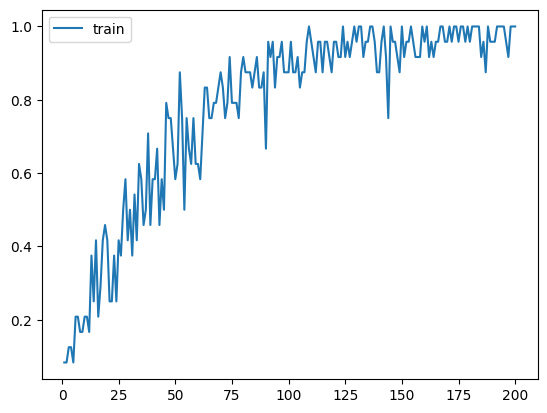

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [51]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia.
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [52]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")


hola
Q: hola
1/1 [==============================] - 0s 31ms/step
BOT: ¡Hola! Estamos aquí para ayudarte.
tengo problemas tecnicos
Q: tengo problemas tecnicos
1/1 [==============================] - 0s 21ms/step
BOT: Lamento escuchar eso. Por favor, descríbeme tu problema con más detalle para que podamos ayudarte mejor.
no funciona el teclado de mi computadora
Q: no funciona el teclado de mi computadora
1/1 [==============================] - 0s 20ms/step
BOT: Debes dirigirte hacia la oficina de tecnicos
en que horarios
Q: en que horarios
1/1 [==============================] - 0s 20ms/step
BOT: Somos una empresa dedicada a brindar soluciones a tus necesidades.
en que horario voy a la oficina de tecnicos
Q: en que horario voy a la oficina de tecnicos
1/1 [==============================] - 0s 37ms/step
BOT: Ofrecemos una variedad de servicios de asistencia para resolver tus problemas.
a que hora voy 
Q: a que hora voy 
1/1 [==============================] - 0s 22ms/step
BOT: Estamos disponi

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")


### 7 - Conclusiones
El modelo actual tiene algunasdificultades para comprender el contexto específico de algunas preguntas. Por ejemplo, en la pregunta "en que horarios," el bot respondió con información general sobre los servicios en lugar de proporcionar una respuesta específica sobre horarios.

Aunque el chatbot responde de manera adecuada a algunas preguntas sobre problemas técnicos y horarios, en ocasiones puede haber confusiones. Por ejemplo, cuando se preguntó "en que horario voy a la oficina de tecnicos," el bot proporcionó información general en lugar de detalles específicos sobre horarios. Esto indica que podría haber margen para mejorar la comprensión de preguntas detalladas.



### Alumno